In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import AISMapPlot as aismap

In [2]:
ais_learners = pd.read_pickle('ROT-HAM_learners_60min.pkl')
ais_learners.head()

,TripID,time,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,remainingMins,dist_to_end,hour_of_day,weekday,day_of_month,month
0,1000226,2016-06-15 14:00:00,369.0,51.0,13.8,51.970000,4.033333,5.200000,112.633333,112.000000,1493.000000,564.248455,14.0,2.0,15.0,6.0
1,1000226,2016-06-15 15:00:00,369.0,51.0,13.8,51.973830,4.046596,9.325532,196.780851,196.914894,1467.595745,564.496867,15.0,2.0,15.0,6.0
2,1000226,2016-06-15 16:00:00,369.0,51.0,13.8,52.134250,3.888500,12.945000,256.532500,345.275000,1395.650000,544.069639,16.0,2.0,15.0,6.0
3,1000226,2016-06-15 17:00:00,369.0,51.0,13.8,52.328793,3.868621,13.075862,153.406897,152.448276,1342.017241,528.601126,17.0,2.0,15.0,6.0
4,1000226,2016-06-15 18:00:00,369.0,51.0,13.8,52.530930,3.936512,12.574419,24.613953,23.418605,1283.046512,470.228412,18.0,2.0,15.0,6.0


In [3]:
X = ais_learners[['Latitude', 'Longitude', 'SOG']]
y = ais_learners['remainingMins']

In [4]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

cv_splits = list(GroupKFold(n_splits = 10).split(X, y, groups = ais_learners['TripID']))

In [5]:
# Create a train-test split
train_indices, test_indicies = cv_splits[0]
X_train, X_test = X.iloc[train_indices], X.iloc[test_indicies]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indicies]

In [ ]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()

lin_params = dict(normalize = [True, False])
lin_grid = GridSearchCV(lin, lin_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error')
lin_grid.fit(X, y)

pd.DataFrame(lin_grid.cv_results_)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

knn_params = dict(n_neighbors = range(1, 50), weights = ['uniform', 'distance'])
knn_rand = RandomizedSearchCV(knn, knn_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error', n_iter = 10)
knn_rand.fit(X, y)

pd.DataFrame(knn_rand.cv_results_)

In [ ]:
knn_best = KNeighborsRegressor(n_neighbors = 41, weights = 'distance')
knn_best.fit(X_train, y_train)

knn_predicts = knn_best.predict(X_test)

In [ ]:
knn_predicts_diffs = knn_predicts - y_test

In [ ]:
knn_predicts_frame = pd.DataFrame({'correct': y_test, 'knn_predicted': knn_predicts, 'diff': knn_predicts_diffs})
knn_predicts_frame['abs_error'] = knn_predicts_frame['diff'].transform(lambda x: abs(x))
knn_predicts_frame = knn_predicts_frame.sort_values('correct')
knn_predicts_frame['abs_error'].describe()

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(knn_predicts_frame['correct'], knn_predicts_frame['diff'])

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfo = RandomForestRegressor()
rfo_params = dict(n_estimators = range(1, 10), max_depth = range(5,15))
rfo_rand = RandomizedSearchCV(rfo, rfo_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error', n_iter = 10)
rfo_rand.fit(X, y)

pd.DataFrame(rfo_rand.cv_results_)

In [6]:
from sklearn.svm import SVR
clf = SVR(C=1.0, epsilon=0.2)
clf.fit(X, y) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [15]:
clf_predicts= clf.predict(X_test)
clf_predicts_diffs = clf_predicts - y_test

In [16]:
clf_predicts_frame = pd.DataFrame({'correct': y_test, 'clf_predicted': clf_predicts, 'diff': clf_predicts_diffs})
clf_predicts_frame['abs_error'] = clf_predicts_frame['diff'].transform(lambda x: abs(x))
clf_predicts_frame = clf_predicts_frame.sort_values('correct')
clf_predicts_frame['abs_error'].describe()

count    1568.000000
mean       99.757461
std       134.853418
min         0.072063
25%        23.211061
50%        52.068253
75%       114.490283
max      1163.434433
Name: abs_error, dtype: float64

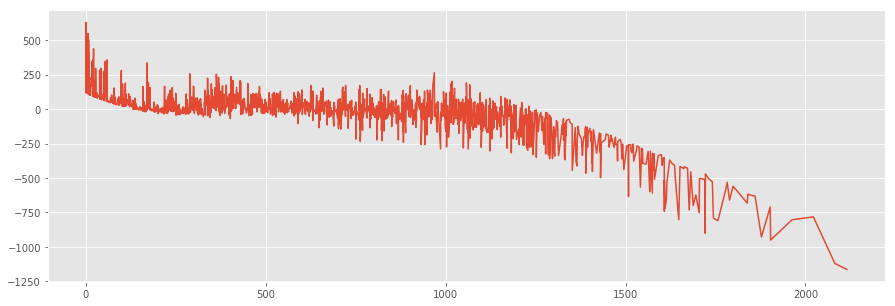

In [17]:
plt.figure(figsize = (15, 5))
plt.plot(clf_predicts_frame['correct'], clf_predicts_frame['diff'])